In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

### Workshop description

In this workshop we will learn how to apply machine learning to unstructured data, specifically to text.

We are going to use a dataset with more than 1.6 millions tweets and has information about the:
* `text` : the tweet
* `polarity` : intensity of the sentiment (from -1 quite negative, to 1 very positive)
* `sentiment` : label of the sentiment (negative, neutral or positive)

The objective is to predict if a tweet is positive, neutral or negative and to do so we are going to:

* learn how to clean that text. 
* pre-process it or transform text data.
* create a sentiment classification model. 


### Dataset Description

The dataset we are going to use is an open source dataset developed by standford university, it is called sentiment140. You can find the description in the following [link](http://help.sentiment140.com/for-students) or in  [kaggle](https://www.kaggle.com/kazanova/sentiment140). However, in my opinion it is not a good dataset since the way to catogorize is terrible, if you do not believe me read this paragraph from the official dataset page. 

>*Our approach was unique because our training data was automatically created, as opposed to having humans manual annotate tweets. In our approach, we assume that any tweet with positive emoticons, like :), were positive, and tweets with negative emoticons, like :(, were negative. We used the Twitter Search API to collect these tweets by using keyword search. This is described in our [paper](https://cs.stanford.edu/people/alecmgo/papers/TwitterDistantSupervision09.pdf)*

To avoid the ***emoticon bias*** I have used an algorithm that compute the intensity of the feeling (polarity) based on the lexicography. The algorithm is called VADER (**V**alence **A**ware **D**ictionary and S**e**ntiment **R**easoner) and, in summary:

> **VADER** uses a combination of a sentiment lexicon is a list of lexical features (e.g., words) which are generally labelled according to their semantic orientation as either positive or negative.<br>
VADER has been found to be quite successful when dealing with social media texts, NY Times editorials, movie reviews, and product reviews. This is because VADER not only tells about the Positivity and Negativity score but also tells us about how positive or negative a sentiment is.*

## TODO:  PUBLIC REPOSITORY


If you want to know more about this algorithm, this [link](https://medium.com/analytics-vidhya/simplifying-social-media-sentiment-analysis-using-vader-in-python-f9e6ec6fc52f) or the [github](https://github.com/cjhutto/vaderSentiment) may help you.

If you want to see the code I used to download the data and apply vader to the data you can read it in the `etl` in this repository (TODO) folder in the files `etl/download.py` and `etl/sentiment.py`

## Dependencies

In [2]:
!cat Pipfile

[[source]]
name = "pypi"
url = "https://pypi.org/simple"
verify_ssl = true

[dev-packages]

[packages]
jupyter = "==1.0.0"
numpy = "==1.19.1"
pandas = "==1.1.1"
matplotlib = "==3.3.1"
scipy = "==1.5.2"
plotnine = "==0.7.1"
scikit-learn = "==0.23.2"
contractions = "==0.0.25"
stop-words = "==2018.7.23"
yellowbrick = "==1.1"
pyarrow = "==1.0.1"
nlp = "==0.4.0"
vadersentiment = "==3.3.2"
nltk = "==3.5"

[requires]
python_version = "3.8"


# 0. Explore the dataset

In [3]:
import pandas as pd

In [4]:
# set pandas options max_colwidth = 1_000 to visualize text
pd.options.display.max_colwidth = 1_000

# data where sentiment140 with vader polarity and sentiment is stored
DATA_PATH_INPUT = './data/sentiment140_vader.csv'

# data where sentiment140 with vader polarity and sentiment is stored
DATA_PATH_OUTPUT = './data/sentiment140_vader_tech_test.json'

# set random seed to enable exact replication
RANDOM_STATE = 42

In [5]:
df = pd.read_csv(DATA_PATH_INPUT)
df.head()

index                          date     query  sentiment  \
0      0  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY          0   
1      1  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY          0   
2      2  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY          0   
3      3  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY          0   
4      4  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY          0   

                                                                                                                  text  \
0  @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D   
1      is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!   
2                            @Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds   
3                                                                      my whole body feels itchy and like its on fire    
4      @nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.    

              user  vader_polarity vader_sentiment  
0  _TheSpecialOne_         -0.0173         neutral  
1    scotthamilton         -0.7500        negative  
2         mattycus          0.4939        positive  
3          ElleCTF         -0.2500        negative  
4           Karoli         -0.4939        negative

#### As we can see in the following tables the feeling created using emoticons (the way standford students did it) generates a very unbalanced label

In [6]:
# sentiment label is quite unbalaced
df['sentiment'].map({4:'positive',0:'negative',2:'neutral'}).value_counts(normalize=True)

positive    0.499958
negative    0.499955
neutral     0.000087
Name: sentiment, dtype: float64

#### However using the VADER algorithm we have a much better distributed label. 

In [7]:
# sentiment label given using vader polarity (sentiment_sensitiviy = 0.1) is better balanced
df['vader_sentiment'].value_counts(normalize=True)

positive    0.458803
neutral     0.290985
negative    0.250212
Name: vader_sentiment, dtype: float64

#### How the feeling class has been created? if the result of VADER is a number between -1 and 1 indicating the intensity of feeling. 

#### Well, very easy 
* 1. first we have analyzed the polarity distribution (intensity of feeling) 
* 2. second we have decided the cuts that determine if the feeling is negative, positive or neutral

<AxesSubplot:ylabel='Density'>

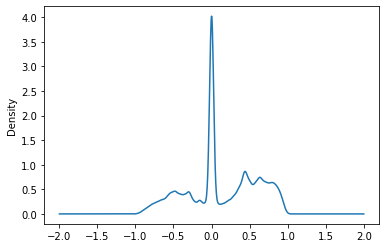

In [8]:
# the density plot of vader_polarity show a clear classification between neutral, positive and negatives tweets
df['vader_polarity'].plot.kde()

#### As we can see in the previous image there is a clear difference between positive, neutral and negative feelings, so we decided that: 
* 1. when the polarity is less than or equal to -0.1 it will be `negative`
* 2. when it is greater than or equal to 0.1 it will be `positive`
* 3. between -0.1 and 0.1, the sentiment will be assigned `neutral`

In [9]:
df.loc[df['vader_polarity']<=-0.1,'vader_sentiment'] = 'negative'
df.loc[df['vader_polarity']>=0.1,'vader_sentiment'] = 'positive'
df.loc[df['vader_sentiment'].isna(),'vader_sentiment'] = 'neutral'

#### Let's check that the feelings are well distributed using density charts (using plotnine, the grammar of graphics)

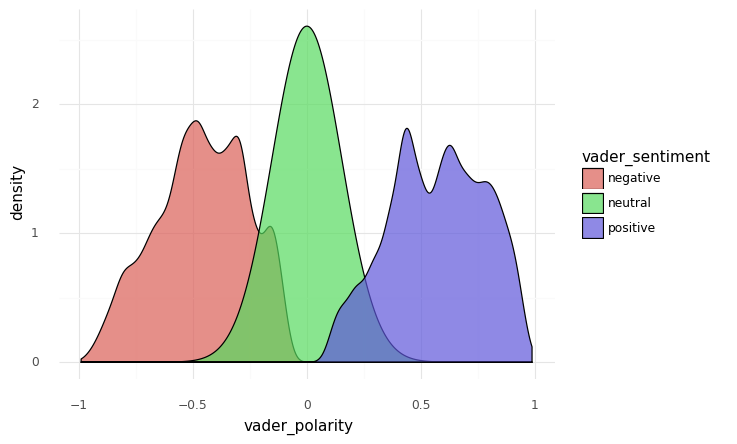

<ggplot: (350298850)>

In [10]:
from plotnine import *
# let's plot those distributions even more clear using a sample of 10_000 rows
ggplot(df.sample(25_000,random_state=RANDOM_STATE),
       aes(x='vader_polarity', fill='vader_sentiment'))+\
    geom_density(alpha=0.7) + theme_minimal()

#### Let's save the result. To do so, we are going  to create a dataset with the `text` in the column `text`, the `vader_polarity` in the columns `polarity` and the `vader_sentiment` in the columns `sentiment` and let's store the data in `json` format

In [11]:
# let's store the output dataset in json format to start the model crafting
columns = ['text', 'vader_polarity' ,'vader_sentiment']
rename_dict = {'vader_sentiment': 'sentiment', 'vader_polarity': 'polarity'}
df[columns].rename(columns=rename_dict).to_json(DATA_PATH_OUTPUT, orient='records')

# 1 . Import Data

In [12]:
df = pd.read_json(DATA_PATH_OUTPUT)
df.head()

text  \
0  @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D   
1      is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!   
2                            @Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds   
3                                                                      my whole body feels itchy and like its on fire    
4      @nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.    

   polarity sentiment  
0   -0.0173   neutral  
1   -0.7500  negative  
2    0.4939  positive  
3   -0.2500  negative  
4   -0.4939  negative

# 2. Tidy Data

##### To show the cleaning process we will use a data sample that allows us to exemplify the different parts of the data cleaning and preprocessing

In [13]:
sample_indexes = [0, 39, 175, 4343, 1600203, 1600072, 1600486]
df_sample = df.loc[sample_indexes].reset_index(drop=True)
df_sample

text  \
0                        @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D   
1                          Bed. Class 8-12. Work 12-3. Gym 3-5 or 6. Then class 6-10. Another day that's gonna fly by. I miss my girlfriend    
2                                                           @machineplay I'm so sorry you're having to go through this. Again.  #therapyfail   
3                                 @kariajay When I was in school I thought I'd be a millionaire at 20 and retire at 21  Look at me today :-P   
4  RT @blknprecious1: RT GREAT @dbroos "Someone's sitting in the shade today because someone planted a tree a long time ago."- Warren Buffet   
5                                                                       RT @SmartChickPDX: Was just told that Nike layoffs started today :-(   
6                                                                       Twitter Stock buzz: $AAPL $ES_F $SPY $SPX $PALM  (updated: 12:00 PM)   

   polarity sentiment  
0   -0.0173   neutral  
1   -0.1531  negative  
2   -0.1880  negative  
3    0.4995  positive  
4    0.7034  positive  
5   -0.3612  negative  
6    0.0000   neutral

##### 2.1. Remove URLS (check out the text in the row 0) 

In [14]:
url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
df_sample['text'] = df_sample['text'].str.replace(url_regex,'',regex=True)
df_sample

text  \
0                                                @switchfoot  - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D   
1                          Bed. Class 8-12. Work 12-3. Gym 3-5 or 6. Then class 6-10. Another day that's gonna fly by. I miss my girlfriend    
2                                                           @machineplay I'm so sorry you're having to go through this. Again.  #therapyfail   
3                                 @kariajay When I was in school I thought I'd be a millionaire at 20 and retire at 21  Look at me today :-P   
4  RT @blknprecious1: RT GREAT @dbroos "Someone's sitting in the shade today because someone planted a tree a long time ago."- Warren Buffet   
5                                                                       RT @SmartChickPDX: Was just told that Nike layoffs started today :-(   
6                                                                       Twitter Stock buzz: $AAPL $ES_F $SPY $SPX $PALM  (updated: 12:00 PM)   

   polarity sentiment  
0   -0.0173   neutral  
1   -0.1531  negative  
2   -0.1880  negative  
3    0.4995  positive  
4    0.7034  positive  
5   -0.3612  negative  
6    0.0000   neutral

##### 2.2. Remove Mentions (remove the @ and the name of the user mentioned. Check out the rows 0 2, 3, 4, 5) 

In [15]:
df_sample['text'] = df_sample['text'].str.replace(r'@\w*','',regex=True)
df_sample

text  \
0                                        - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D   
1     Bed. Class 8-12. Work 12-3. Gym 3-5 or 6. Then class 6-10. Another day that's gonna fly by. I miss my girlfriend    
2                                                   I'm so sorry you're having to go through this. Again.  #therapyfail   
3                      When I was in school I thought I'd be a millionaire at 20 and retire at 21  Look at me today :-P   
4  RT : RT GREAT  "Someone's sitting in the shade today because someone planted a tree a long time ago."- Warren Buffet   
5                                                                RT : Was just told that Nike layoffs started today :-(   
6                                                  Twitter Stock buzz: $AAPL $ES_F $SPY $SPX $PALM  (updated: 12:00 PM)   

   polarity sentiment  
0   -0.0173   neutral  
1   -0.1531  negative  
2   -0.1880  negative  
3    0.4995  positive  
4    0.7034  positive  
5   -0.3612  negative  
6    0.0000   neutral

##### 2.3. Remove Hashtags  (Check out the rows 2) 

In [16]:
df_sample['text'] = df_sample['text'].str.replace(r'#\w*','',regex=True)
df_sample

text  \
0                                        - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D   
1     Bed. Class 8-12. Work 12-3. Gym 3-5 or 6. Then class 6-10. Another day that's gonna fly by. I miss my girlfriend    
2                                                               I'm so sorry you're having to go through this. Again.     
3                      When I was in school I thought I'd be a millionaire at 20 and retire at 21  Look at me today :-P   
4  RT : RT GREAT  "Someone's sitting in the shade today because someone planted a tree a long time ago."- Warren Buffet   
5                                                                RT : Was just told that Nike layoffs started today :-(   
6                                                  Twitter Stock buzz: $AAPL $ES_F $SPY $SPX $PALM  (updated: 12:00 PM)   

   polarity sentiment  
0   -0.0173   neutral  
1   -0.1531  negative  
2   -0.1880  negative  
3    0.4995  positive  
4    0.7034  positive  
5   -0.3612  negative  
6    0.0000   neutral

##### 2.4. Remove Retweet symbol (RT)  (Check out the rows 4) 

In [17]:
df_sample['text'] = df_sample['text'].str.replace(r'RT','',regex=True)
df_sample

text  \
0                                     - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D   
1  Bed. Class 8-12. Work 12-3. Gym 3-5 or 6. Then class 6-10. Another day that's gonna fly by. I miss my girlfriend    
2                                                            I'm so sorry you're having to go through this. Again.     
3                   When I was in school I thought I'd be a millionaire at 20 and retire at 21  Look at me today :-P   
4    :  GREAT  "Someone's sitting in the shade today because someone planted a tree a long time ago."- Warren Buffet   
5                                                                : Was just told that Nike layoffs started today :-(   
6                                               Twitter Stock buzz: $AAPL $ES_F $SPY $SPX $PALM  (updated: 12:00 PM)   

   polarity sentiment  
0   -0.0173   neutral  
1   -0.1531  negative  
2   -0.1880  negative  
3    0.4995  positive  
4    0.7034  positive  
5   -0.3612  negative  
6    0.0000   neutral

##### 2.5. Lowercase (that simple)

In [18]:
df_sample['text'] = df_sample['text'].str.lower()
df_sample

text  \
0                                     - awww, that's a bummer.  you shoulda got david carr of third day to do it. ;d   
1  bed. class 8-12. work 12-3. gym 3-5 or 6. then class 6-10. another day that's gonna fly by. i miss my girlfriend    
2                                                            i'm so sorry you're having to go through this. again.     
3                   when i was in school i thought i'd be a millionaire at 20 and retire at 21  look at me today :-p   
4    :  great  "someone's sitting in the shade today because someone planted a tree a long time ago."- warren buffet   
5                                                                : was just told that nike layoffs started today :-(   
6                                               twitter stock buzz: $aapl $es_f $spy $spx $palm  (updated: 12:00 pm)   

   polarity sentiment  
0   -0.0173   neutral  
1   -0.1531  negative  
2   -0.1880  negative  
3    0.4995  positive  
4    0.7034  positive  
5   -0.3612  negative  
6    0.0000   neutral

##### 2.6. Fix verb contractions (he's to he is, you'r to you are)

In [19]:
# vectorize the function to scale better 
from contractions import fix
fix_contractions = np.vectorize(lambda string: str(fix(string)))

df_sample['text'] = fix_contractions(df_sample['text'])
df_sample


text  \
0                                        - awww, that is a bummer.  you shoulda got david carr of third day to do it. ;d   
1  bed. class 8-12. work 12-3. gym 3-5 or 6. then class 6-10. another day that is going to fly by. i miss my girlfriend    
2                                                              I am so sorry you are having to go through this. again.     
3                   when i was in school i thought I would be a millionaire at 20 and retire at 21  look at me today :-p   
4        :  great  "someone's sitting in the shade today because someone planted a tree a long time ago."- warren buffet   
5                                                                    : was just told that nike layoffs started today :-(   
6                                                   twitter stock buzz: $aapl $es_f $spy $spx $palm  (updated: 12:00 pm)   

   polarity sentiment  
0   -0.0173   neutral  
1   -0.1531  negative  
2   -0.1880  negative  
3    0.4995  positive  
4    0.7034  positive  
5   -0.3612  negative  
6    0.0000   neutral

##### 2.7. Remove everything but a letter  (Check out all rows, numbers, smilies, dollar symbols, etc )

In [20]:
df_sample['text'] = df_sample['text'].str.replace(r"[^a-z]",' ',regex=True)
df_sample

text  \
0                                          awww  that is a bummer   you shoulda got david carr of third day to do it   d   
1  bed  class       work       gym     or    then class       another day that is going to fly by  i miss my girlfriend    
2                                                                am so sorry you are having to go through this  again      
3                   when i was in school i thought   would be a millionaire at    and retire at     look at me today   p   
4           great   someone s sitting in the shade today because someone planted a tree a long time ago    warren buffet   
5                                                                      was just told that nike layoffs started today       
6                                                   twitter stock buzz   aapl  es f  spy  spx  palm   updated        pm    

   polarity sentiment  
0   -0.0173   neutral  
1   -0.1531  negative  
2   -0.1880  negative  
3    0.4995  positive  
4    0.7034  positive  
5   -0.3612  negative  
6    0.0000   neutral

##### 2.8. Remove duplicate letters in words (from Awwww to Aw) (Check out row 0, Note also the error in the row 6 with Twiter word ))

In [21]:
df_sample['text'] = df_sample['text'].str.replace(r'(\w)\1+',r'\1',regex=True)
df_sample

text  \
0                                           aw  that is a bumer   you shoulda got david car of third day to do it   d   
1  bed  clas       work       gym     or    then clas       another day that is going to fly by  i mis my girlfriend    
2                                                              am so sory you are having to go through this  again      
3                   when i was in schol i thought   would be a milionaire at    and retire at     lok at me today   p   
4            great   someone s siting in the shade today because someone planted a tre a long time ago    waren bufet   
5                                                                    was just told that nike layofs started today       
6                                                   twiter stock buz   apl  es f  spy  spx  palm   updated        pm    

   polarity sentiment  
0   -0.0173   neutral  
1   -0.1531  negative  
2   -0.1880  negative  
3    0.4995  positive  
4    0.7034  positive  
5   -0.3612  negative  
6    0.0000   neutral

##### 2.9. Remove words with one or two letters (d, i, pm, ...)

In [22]:
df_sample['text'] = df_sample['text'].replace(r'\b\w{1,2}\b', '', regex =True)
df_sample

text  \
0                                                that   bumer   you shoulda got david car  third day         
1  bed  clas       work       gym         then clas       another day that  going  fly    mis  girlfriend    
2                                                             sory you are having   through this  again      
3                        when  was  schol  thought   would   milionaire     and retire      lok   today      
4      great   someone  siting  the shade today because someone planted  tre  long time ago    waren bufet   
5                                                         was just told that nike layofs started today       
6                                             twiter stock buz   apl     spy  spx  palm   updated            

   polarity sentiment  
0   -0.0173   neutral  
1   -0.1531  negative  
2   -0.1880  negative  
3    0.4995  positive  
4    0.7034  positive  
5   -0.3612  negative  
6    0.0000   neutral

##### 2.10.  Remove duplicate spaces and spaces at the beginning and at the end of the string

In [23]:
## remove duplicates spaces and strip
df_sample['text'] = df_sample['text'].str.replace(r' +',' ',regex=True).str.strip()
df_sample

text  \
0                                              that bumer you shoulda got david car third day   
1                       bed clas work gym then clas another day that going fly mis girlfriend   
2                                                      sory you are having through this again   
3                                when was schol thought would milionaire and retire lok today   
4  great someone siting the shade today because someone planted tre long time ago waren bufet   
5                                                was just told that nike layofs started today   
6                                                   twiter stock buz apl spy spx palm updated   

   polarity sentiment  
0   -0.0173   neutral  
1   -0.1531  negative  
2   -0.1880  negative  
3    0.4995  positive  
4    0.7034  positive  
5   -0.3612  negative  
6    0.0000   neutral

##### 2.11.  Remove stop words (in english)

In [24]:
from stop_words import get_stop_words
stop_words = set(get_stop_words('english'))

df_sample['text'] = df_sample['text'].str.split(' ').map(lambda seq:[word for word in seq if word not in stop_words])
df_sample

text  \
0                                                 [bumer, shoulda, got, david, car, third, day]   
1                       [bed, clas, work, gym, clas, another, day, going, fly, mis, girlfriend]   
2                                                                                        [sory]   
3                                              [schol, thought, milionaire, retire, lok, today]   
4  [great, someone, siting, shade, today, someone, planted, tre, long, time, ago, waren, bufet]   
5                                                    [just, told, nike, layofs, started, today]   
6                                            [twiter, stock, buz, apl, spy, spx, palm, updated]   

   polarity sentiment  
0   -0.0173   neutral  
1   -0.1531  negative  
2   -0.1880  negative  
3    0.4995  positive  
4    0.7034  positive  
5   -0.3612  negative  
6    0.0000   neutral

##### 2.12.  Stemming (Taking the roots, fast)

***Stemming and Lemmatization***

Stemming is a way to simplify a word by using its root. Strictly speaking
, Stemming is "the process of producing morphological variants of a root/base word". 

A stemmer makes transformation like theeese ones

```python 
run       --> run
runner    --> runner
running   --> run
ran       --> ran
runs      --> run
easily    --> easili
fairly    --> fairli
````

There is another way to find the root of a word called lemmatization. In contrast to stemming, lemmatization looks beyond word reduction and considers a language’s full vocabulary to apply a morphological analysis to words. A lemmatization algorithm is more "accurate" because it's find the actual word root.

```python 
was       --> be
mice      --> mouse
```

As you may be thinking Stemming is fasterthan Lemmatizing, and among all the Stemming algorithms of  the fastest is the PorterStemmer

In [26]:
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
# double vectorization (yes we can)
stemmer_vec = np.vectorize(np.vectorize(stemmer.stem,otypes=[str]), otypes=[list])
df_sample['text'] = stemmer_vec(df_sample['text'])
df_sample

text  \
0                                           [bumer, shoulda, got, david, car, third, day]   
1                         [bed, cla, work, gym, cla, anoth, day, go, fli, mi, girlfriend]   
2                                                                                  [sori]   
3                                          [schol, thought, milionair, retir, lok, today]   
4  [great, someon, site, shade, today, someon, plant, tre, long, time, ago, waren, bufet]   
5                                                 [just, told, nike, layof, start, today]   
6                                        [twiter, stock, buz, apl, spi, spx, palm, updat]   

   polarity sentiment  
0   -0.0173   neutral  
1   -0.1531  negative  
2   -0.1880  negative  
3    0.4995  positive  
4    0.7034  positive  
5   -0.3612  negative  
6    0.0000   neutral

### 2.13.  Create a Sklearn-Friendly Transformer (name it for instance TweeTidy)

In [28]:
#!/usr/local/bin/python
from stop_words import get_stop_words
from nltk.stem import PorterStemmer
from contractions import fix
from numpy import vectorize
from pandas import Series

fix_contractions = vectorize(lambda string: str(fix(string)))


class TweetTidy:
    
    @staticmethod
    def __replace(serie, regex, by = ''):
        return serie.str.replace(regex, by ,regex=True)
        
    def fit(self, X=None, y=None, 
            stop_words = get_stop_words('english'), 
            stemmer = PorterStemmer):
        self.stop_words = set(stop_words)
        
        try:
            self.stemmer = stemmer()
        except:
            self.stemmer = stemmer
        self.stemmer_vec = vectorize(vectorize(self.stemmer.stem,otypes=[str]), otypes=[list])
        return self
    
    def transform(self, X):
        serie = Series(X)
        # 1. remove urls
        url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
        serie = self.__replace(serie, url_regex)
        # 2. remove mentions '@estebanmoro Hi there' -> 'Hi there'
        serie = self.__replace(serie, r'@\w*')
        # 3. remove hashtag 'look at this graph #covid' -> 'look at this graph'
        serie = self.__replace(serie, r'#\w*')
        # 4. remove retweets word RT (the rest of the tweet remains)
        serie = self.__replace(serie, r'RT')
        # 5. lowercase, strip 
        serie = serie.str.lower()
        # 6. fix contractions "that's" -> that is
        serie = Series(fix_contractions(serie)) 
        # 7. remove all but letters and aphotrophes
        serie = self.__replace(serie, r"[^a-zA-Z]", ' ')
        # 8. remove duplicated letters  awwww -> aw
        serie = self.__replace(serie, r'(\w)\1+', r'\1')
        # 9. remove words with 1 letter
        serie = self.__replace(serie, r'\b\w{1,1}\b')
        # 10 remove duplicated spaces and strip
        serie = self.__replace(serie, r' +',' ').str.strip()
        # 11. remove stop words and get unique words
        serie = serie.str.split(' ').map(lambda i: list(filter(lambda j: j not in self.stop_words, i)))
        # 12. Stemmer
        array = self.stemmer_vec(serie)
        # return string
        return Series(array).map(lambda i: ' '.join(i))
    
    def fit_transform(self, X=None, y=None, 
                      stop_words = get_stop_words('english'), 
                      stemmer = PorterStemmer):
        return self.fit(X, y, stop_words=stop_words, stemmer=stemmer).transform(X)

# 3. Transform

### 3.1 Splits (X | y) and (Train | Test)
Before any kind of transformation it is better to make a split between train and test. 

Although all the transformations that we are going to apply are "row-wise" and therefore it would not be strictly necessary to make the split between train and test, it is better to make the split before any type of transformation or cleaning in order not to corrupt the test data with train information (remember the "future information" problem)

We will divide the dataset into train(75%) and test(25%) with a random division but stratifying by the class to be predicted. To make the code reproducible, control the random_state

* Keep in mind that both X and y must be numerical data, (the following clue will help you)
````python
label_dict ={'positive':1, 'negative':-1,'neutral':0}
````


In [29]:
%%time
# clean X and y
label_dict = {'positive':1, 'negative':-1,'neutral':0}
X = df['text']
y = df['sentiment'].map(label_dict)

CPU times: user 223 ms, sys: 1.84 ms, total: 225 ms
Wall time: 223 ms


In [31]:
%%time
from sklearn.model_selection import train_test_split
# spit in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    stratify=y, 
                                                    random_state=RANDOM_STATE)

CPU times: user 912 ms, sys: 22.2 ms, total: 934 ms
Wall time: 934 ms


## 3.2 Clean train data

In [32]:
X_train.head()

1008269                            @Documentally It's a father's duty to teach his son that life is for enjoying - make good use of your time together 
1130723                                Back from band practice, and I'm temporarily deaf in my left ear. fml, but hey I get red lobster. so s'all good 
365180     Wow, just woke up from a nap. A year older &amp; I have 2 NAP! What else happens when u get older limbs fall off? What is a old woman 2 do? 
1162865              @rachael211 FF were awesome  Ed nearly kicked my camera out of my hand cos he decided to jump over the barrier right next to me XD
878254                                                                                                    just booked my flight back home! can't wait! 
Name: text, dtype: object

In [37]:
%%time
import gc
tweet_transformer = TweetTidy().fit(X_train)
X_train_tidy = tweet_transformer.transform(X=X_train)
gc.collect()

CPU times: user 67.5 ms, sys: 553 µs, total: 68 ms
Wall time: 67.8 ms


120

### 3.2.1 Compre the original and the output

In [39]:
X_train.head()

1008269                            @Documentally It's a father's duty to teach his son that life is for enjoying - make good use of your time together 
1130723                                Back from band practice, and I'm temporarily deaf in my left ear. fml, but hey I get red lobster. so s'all good 
365180     Wow, just woke up from a nap. A year older &amp; I have 2 NAP! What else happens when u get older limbs fall off? What is a old woman 2 do? 
1162865              @rachael211 FF were awesome  Ed nearly kicked my camera out of my hand cos he decided to jump over the barrier right next to me XD
878254                                                                                                    just booked my flight back home! can't wait! 
Name: text, dtype: object

In [38]:
X_train_tidy.head()

0                      father duti teach son life enjoy make god use time togeth
1     back band practic temporarili deaf left ear fml hey get red lobster al god
2    wow just woke nap year older amp nap els hapen get older limb fal old woman
3           awesom ed nearli kick camera hand co decid jump barier right next xd
4                                            just boke flight back home can wait
dtype: object

## 3.3 Preprocessing - TFiDF

### 3.3.1 Explain TFIDF

<img src="https://miro.medium.com/max/1400/1*ImQJjYGLq2GE4eX40Mh28Q.png" width=600 height=600 />


TF-IDF is an abbreviation for Term Frequency Inverse Document Frequency. This is very common algorithm to transform text into a meaningful representation of numbers which is used to fit machine algorithm for prediction. Let's make an easy example to understand how it's works

In [41]:
text = ['The sky is blue.', 
         'The sun is bright.']

If we just count the frequency of each word per document (line or tweet) we have this result (Using CountVectorizer)

In [43]:
from sklearn.feature_extraction.text import CountVectorizer
count_vec = CountVectorizer()
pd.DataFrame(data = count_vec.fit_transform(text).toarray(),columns = count_vec.get_feature_names())

blue  bright  is  sky  sun  the
0     1       0   1    1    0    1
1     0       1   1    0    1    1

But if we use the TfidfVectorizer we get a similar matrix with different values

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vec = TfidfVectorizer()
pd.DataFrame(data = tfidf_vec.fit_transform(text).toarray(),columns = tfidf_vec.get_feature_names())

blue    bright        is       sky       sun       the
0  0.576152  0.000000  0.409937  0.576152  0.000000  0.409937
1  0.000000  0.576152  0.409937  0.000000  0.576152  0.409937

We know the TF term (done using CountVectorizer) but, how is the IDF term?

In [45]:
dict(zip(tfidf_vec.vocabulary_.keys(),tfidf_vec.idf_))

{'the': 1.4054651081081644,
 'sky': 1.4054651081081644,
 'is': 1.0,
 'blue': 1.4054651081081644,
 'sun': 1.4054651081081644,
 'bright': 1.0}

For example, the word `sky` appeas in 1 of 2 documents, so the IDF is calculate as folloes

In [46]:
n_documents = 2
n_documents_in_which_appers=1
np.log((n_documents+1)/(n_documents_in_which_appers+1))+1

1.4054651081081644

The TFiDF is the product between the TF of each word in each document times the IDF of each word (an then we apply a Standardization in thi case L2)

### 3.3.2 Apply TFIDF

In [61]:
from itertools import chain
n_words_train = int(len(set(chain(*X_train_tidy.map(lambda i: i.split(' ')).values))))
max_words = round(n_words_train*0.1)
print(f'We have {n_words_train} unique words in train, so we are going to use the 10%, {max_words} words')

We have 142417 unique words in train, so we are going to use the 10%, 14242 words


##### The output is a sparse matrix with a row per tweet in train a a column per word (14242). The values of word_i_j is the tfidf value of the word j in the tweet i

In [62]:
%%time
tfidf_vec = TfidfVectorizer(max_features=max_words)
X_train_transform = tfidf_vec.fit_transform(X_train_tidy)
X_train_transform.shape

CPU times: user 9.02 s, sys: 127 ms, total: 9.15 s
Wall time: 9.16 s


(1200373, 14242)

In [63]:
X_train_transform

<1200373x14242 sparse matrix of type '<class 'numpy.float64'>'
	with 7925487 stored elements in Compressed Sparse Row format>

## 4. Model - Linear Support Vector Machine for Classification

### 4.1 Model Explanation

SVMs are supervised machine learning models that are usually employed for classification (SVC — Support Vector Classification). 

The SVCs aim to find the best hyperplane (also called decision boundary) that best separates (splits) a dataset into two classes/groups (binary classification problem).

The Support vectors are just the samples (data-points) that are located nearest to the separating hyperplane. These samples would alter the position of the separating hyperplane, in the event of their removal. Thus, these are the most important samples that define the location and orientation of best decision boundary.

The distance between the hyperplane and the nearest data points (samples) is known as the SVM margin. The goal is to choose a hyperplane with the greatest possible margin between the hyperplane and any support vector. SVM algorithm finds the best decision boundary such as the margin is maximized. 

In the next picture we can see a SVC (Suport Vector Machine for Classification) that separates red data from blue data, using the Support Vector (in yellow) and Maximiizing the margin (blue line), so that we can find the best linear hiperplane that separate best blue dots from red ones

<img src="https://static.packt-cdn.com/products/9781789345070/graphics/6a831600-9a0d-429f-9d34-d957c45b9517.png" width=600 height=600 />


### 4.2. Model Fit

In [65]:
%%time
from sklearn.svm import LinearSVC
model_clf = LinearSVC(random_state=RANDOM_STATE, penalty='l1', dual=False)
model_clf.fit(X_train_transform, y_train)

CPU times: user 1min 43s, sys: 426 ms, total: 1min 44s
Wall time: 1min 44s


LinearSVC(dual=False, penalty='l1', random_state=42)

## 5. Predict

### 5.1 Tidy and Transform Test

In [66]:
%%time
X_test_tidy = tweet_transformer.transform(X=X_test)

CPU times: user 1min 11s, sys: 376 ms, total: 1min 11s
Wall time: 1min 12s


In [67]:
%%time
X_test_transform = tfidf_vec.transform(X_test_tidy)

CPU times: user 3.2 s, sys: 44.5 ms, total: 3.24 s
Wall time: 3.25 s


### 5.2 Predict

In [68]:
%%time
y_pred = model_clf.predict(X_test_transform)

CPU times: user 29.1 ms, sys: 4.99 ms, total: 34.1 ms
Wall time: 32.8 ms


# 6. Evaluate

In [69]:
from sklearn.metrics import classification_report, cohen_kappa_score, accuracy_score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.83      0.77      0.80    100116
           0       0.87      0.86      0.86    116430
           1       0.87      0.92      0.90    183579

    accuracy                           0.86    400125
   macro avg       0.86      0.85      0.85    400125
weighted avg       0.86      0.86      0.86    400125



In [70]:
print('Cohen Kappa:', round(cohen_kappa_score(y_test, y_pred),3))

Cohen Kappa: 0.785


I like the the **kappa cohen metric** because it measures how much better your model is compared to a random model (which takes into account the proportion of each label). 

The formula is quite easy:
$$Kappa = \frac{Accuracy - ExpectedAccuracy}{1-ExpectedAccuracy}$$

where $Accuracy$ is the accuracy of our model and the $Expected Accuracy$ is the accuracy of a random model that only takes into account the frequency of each label. 

The expected Accuracy is 
$$ExpectedAccuracy = \frac{Accuracy - Kappa}{1-Kappa}$$

Cohen suggested the Kappa result be interpreted as follows: values ≤ 0 as indicating no agreement and 0.01–0.20 as none to slight, 0.21–0.40 as fair, 0.41– 0.60 as moderate, 0.61–0.80 as substantial, and 0.81–1.00 as almost perfect agreement.

So our result ($Kappa = 0.785$) is substantial aggrement

In [71]:
expected_accuracy = (accuracy_score(y_test,y_pred) - cohen_kappa_score(y_test, y_pred)) / (1-cohen_kappa_score(y_test, y_pred))
print('Epected Accuracy:', round(expected_accuracy,3))

Epected Accuracy: 0.362


**The Expected Accurary (Acuracy of a random model) is 0.36 and the Accuracy of our model is 0.85**


You can find a great explanation of what is the Cohen Kappa is plain english [here](https://stats.stackexchange.com/questions/82162/cohens-kappa-in-plain-english)

# 7. Production ready 

### 7.1 Let's create a pipeline that wrap all the transformations and themodel

In [75]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline([('tidy', TweetTidy()), 
                      ('transform', TfidfVectorizer(ngram_range=(1,2), use_idf=False, max_features=max_words)), 
                      ('model', LinearSVC(random_state=RANDOM_STATE, penalty='l1', dual=False))])
pipeline

Pipeline(steps=[('tidy', <__main__.TweetTidy object at 0x249de7760>),
                ('transform',
                 TfidfVectorizer(max_features=14242, ngram_range=(1, 2),
                                 use_idf=False)),
                ('model',
                 LinearSVC(dual=False, penalty='l1', random_state=42))])

In [76]:
%%time
pipeline.fit(X_train, y_train)

CPU times: user 6min 5s, sys: 2.39 s, total: 6min 7s
Wall time: 6min 8s


Pipeline(steps=[('tidy', <__main__.TweetTidy object at 0x249de7760>),
                ('transform',
                 TfidfVectorizer(max_features=14242, ngram_range=(1, 2),
                                 use_idf=False)),
                ('model',
                 LinearSVC(dual=False, penalty='l1', random_state=42))])

In [77]:
%%time
y_pred = pipeline.predict(X_test)

CPU times: user 1min 20s, sys: 555 ms, total: 1min 20s
Wall time: 1min 21s


# 8. Evaluation: metrics and graphs

In short the evaluation of the model is great, an accuracy of 87% and a cohen kappa 80%

We also see that the accuracy, precision and recall is good and stable in all classes (positive 1, neutral 0, and negative -1). 


If we look at the ROC curve, we see that the predictive capacity of the model does not depend on the threshold and is equivalent in all three classes (it has an AUC of 0.93 in positive and negative and 0.95 in neutral

In [78]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.83      0.77      0.80    100116
           0       0.87      0.86      0.87    116430
           1       0.88      0.92      0.90    183579

    accuracy                           0.87    400125
   macro avg       0.86      0.85      0.86    400125
weighted avg       0.87      0.87      0.87    400125



In [79]:
print('Cohen Kappa:', round(cohen_kappa_score(y_test, y_pred),3))

Cohen Kappa: 0.79


/Users/frandiego/.local/share/virtualenvs/twitter_sentiment_classifier-SpupmiWu/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
/Users/frandiego/.local/share/virtualenvs/twitter_sentiment_classifier-SpupmiWu/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


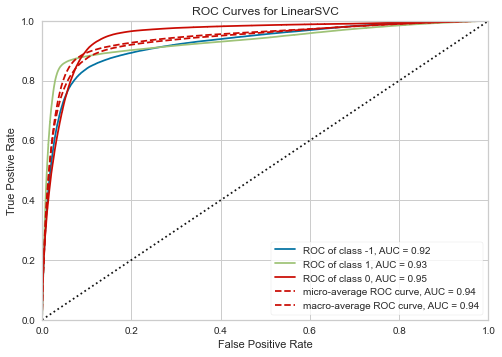

CPU times: user 2min 38s, sys: 930 ms, total: 2min 39s
Wall time: 2min 39s


<AxesSubplot:title={'center':'ROC Curves for LinearSVC'}, xlabel='False Positive Rate', ylabel='True Postive Rate'>

In [80]:
%%time
from yellowbrick.classifier import ROCAUC
visualizer = ROCAUC(pipeline, classes=y_train.unique())
visualizer.fit(X_train, y_train)       
visualizer.score(X_test, y_test) 
visualizer.show()

# 9. Cross Validation

We are going to do a cross validation to ensure that the metrics we have come up with (so good) are stable.


We have taken a sample of 1000 tweets and we do a cross validation of 3 folds.

We see that the accuracy and cohen cappa is slightly lower in test than in train, but the metrics are stable in all three folds. With what passes the cross validation, ie the model is robust. 

In [81]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import make_scorer

In [82]:
np.random.seed(RANDOM_STATE)
sample_indexes = np.random.randint(0, len(X_train), size= 100_000)
X_sample, y_sample = X_train.iloc[sample_indexes], y_train.iloc[sample_indexes]

In [83]:
%%time
## Let's tidy first
X_sample = TweetTidy().fit_transform(X_sample)

CPU times: user 18.5 s, sys: 75.8 ms, total: 18.6 s
Wall time: 18.6 s


In [87]:
%%time
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
pipeline_cv = pipeline[1:]
cv_folds = 5
scoring_dict = {'cohen_kappa': make_scorer(cohen_kappa_score), 
                'accuracy': make_scorer(accuracy_score)}

cv_scores = cross_validate(pipeline_cv, 
                            X_sample, y_sample,
                            cv=cv_folds,
                            scoring=scoring_dict,
                            return_train_score=True)

CPU times: user 35.1 s, sys: 208 ms, total: 35.3 s
Wall time: 35.4 s


In [88]:
aux = pd.DataFrame(cv_scores).reset_index().rename(columns={'index':'fold'}).melt('fold')
aux = aux[~aux['variable'].str.contains('time')]
aux.loc[:,['type']] = list(np.where(aux['variable'].str.contains('train'),'train','test'))
aux['variable'] = aux['variable'].replace(r'test_|train_','',regex=True)

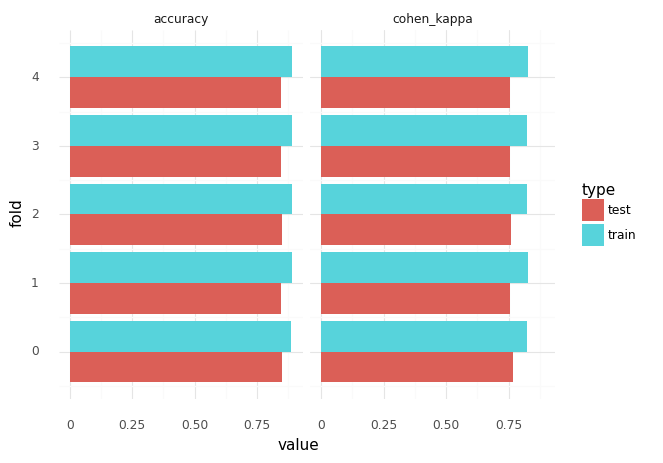

<ggplot: (845105643)>

In [89]:
from plotnine import *
ggplot(aux, aes('fold','value',fill='type'))+\
geom_col(position='dodge') +\
facet_wrap('variable')+\
coord_flip()+\
theme_minimal()